In [2]:
# Dependencies not on Colab

! pip install -q datasets
# ! pip install bertopic  # <-- TOO MANY DEPENDENCIES!!!! NOT WORTH IT

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.2 MB/s eta 0:00:00


In [3]:
# Main libraries imports

import requests
import pandas as pd
import nltk
import tqdm
import re
import numpy as np
import matplotlib.pyplot as plt
import warnings
import logging
from collections import Counter
import spacy

plt.style.use('fivethirtyeight')

# pd.options.display.max_colwidth = None

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from google.colab import userdata
# userdata.get('HF_TOKEN')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
nltk.__version__

'3.8.1'

## Data: Bitext - Customer Service Tagged Training Dataset for LLM-based Virtual Assistants

source: https://huggingface.co/datasets/bitext/Bitext-customer-support-llm-chatbot-training-dataset

The original dataset is meant for intent detection. Intent detection is a supervised learning task used often to finetune LLM to be adapted for AI chatbots. This helps chatbots understand user requests and respond approriately.

The dataset sourced from Bitext, have been selected from Bitext's collection of 20 vertical-specific datasets, covering the intents that are common across all 20 verticals. The verticals are:

Automotive, Retail Banking, Education, Events & Ticketing, Field Services, Healthcare, Hospitality, Insurance, Legal Services, Manufacturing, Media Streaming, Mortgages & Loans, Moving & Storage, Real Estate/Construction, Restaurant & Bar Chains, Retail/E-commerce, Telecommunications, Travel, Utilities, Wealth Management

more about verticals: https://www.bitext.com/chatbot-verticals/

It also contains 12 tags/flags used to identify the linguistic style, which will also be ignored by Optibot for this task.

This dataset already contains labels for categories and intents, which are as follows

1. ACCOUNT
2. CANCELLATION_FEE
3. DELIVERY
4. FEEDBACK
5. INVOICE
6. NEWSLETTER
7. ORDER
8. PAYMENT
9. REFUND
10. SHIPPING_ADDRESS

Yet, Optibot starts it's journey as a unsupervised learning teqnique to catalog the conversations, using topic modeling (either LDA, NMF or LSA). Optibot will ignore these intents, as the purpose of Optibot is that via topic modling, it will come up with its own categories. At the end, we can actually use these predefined categories as an evaluation criteria, though.

### Unused ways to retrive the data

In [ ]:
# # URL from where the dataset is to be loaded
# url = "https://datasets-server.huggingface.co/rows?dataset=bitext%2FBitext-customer-support-llm-chatbot-training-dataset&config=default&split=train&offset=0" # &length=100
# # Making a GET request to fetch the data
# response = requests.get(url)
# data = response.json()

# from datasets import load_dataset
# dataset = load_dataset("bitext/Bitext-customer-support-llm-chatbot-training-dataset")

### Load Data

In [4]:
bitext_df = pd.read_csv("https://raw.githubusercontent.com/bitext/customer-support-llm-chatbot-training-dataset/main/data/Bitext_Sample_Customer_Support_Training_Dataset_27K_responses-v11.csv")
display(bitext_df.sample(8))
print(len(bitext_df))

,flags,instruction,category,intent,response
8682,BIL,how do I see what hours I can contact customer...,CONTACT,contact_customer_service,Thank you for reaching out! I completely under...
17341,BL,I need help signing up to the newsletter,SUBSCRIPTION,newsletter_subscription,That's great to hear that you're eager to sign...
18435,BLMQ,want assistance to inform of troubles with pay...,PAYMENT,payment_issue,I'm here to provide you with the assistance yo...
24660,BL,I want assistance to change to the freemium ac...,ACCOUNT,switch_account,We appreciate your inquiry and expressing your...
22603,BILQZ,how to sends some feedback for ur products,FEEDBACK,review,Thank you for expressing your interest in prov...
21929,BL,help me submit some feedback about a product,FEEDBACK,review,We appreciate your desire to share your feedba...
10962,BEL,I do not know how to close a {{Account Categor...,ACCOUNT,delete_account,I've realized that you're unsure about how to ...
21955,BL,I try to leave some feedback about your services,FEEDBACK,review,We truly appreciate your interest in sharing y...


26872


### Join instruction and response

In [5]:
bitext_df["conversation"] = "Question: " + bitext_df["instruction"] + " Answer: " + bitext_df["response"]
bitext_df.head(1)

,flags,instruction,category,intent,response,conversation
0,B,question about cancelling order {{Order Number}},ORDER,cancel_order,I've understood you have a question regarding ...,Question: question about cancelling order {{Or...


## Topic Modeling with Gensim

#### Corpus by Words and Text-preprocessing

In [26]:
# TODO: try with spacy to see if it's faster
stop_words = nltk.corpus.stopwords.words('english')
wtk = nltk.tokenize.RegexpTokenizer(r'\w+')
wnl = nltk.stem.wordnet.WordNetLemmatizer()

def normalize_corpus(conversations):
    norm_conversations = []
    for conversation in tqdm.tqdm(conversations):
        conversation = conversation.lower()
        # remove entities:
        conversation = re.sub(r'\{\{.*?\}\}', '', conversation)
        # tokenize and lemmatize:
        conversation_tokens = [token.strip() for token in wtk.tokenize(conversation)]
        conversation_tokens = [wnl.lemmatize(token) for token in conversation_tokens if not token.isnumeric()]
        # removing any single character words \ numbers \ symbols:
        conversation_tokens = [token for token in conversation_tokens if len(token) > 1]
        # remove stop words:
        conversation_tokens = [token for token in conversation_tokens if token not in stop_words]
        # remove faulty types and empty conersations:
        conversation_tokens = list(filter(None, conversation_tokens))
        if conversation_tokens:
            norm_conversations.append(conversation_tokens)

    return norm_conversations

norm_conversations = normalize_corpus(bitext_df["conversation"].to_list())
print(len(norm_conversations))

100%|██████████| 26872/26872 [00:26<00:00, 997.73it/s] 

26872


#### Build Bigram and BOW corpus

In [7]:
import gensim

bigram = gensim.models.Phrases(norm_conversations, min_count=20, threshold=10, delimiter='_')
# Note: This Phrases detects common words that usually go together (New York), and fuses them together
#       it is not a pre-trained model, and learns based on statistical occurance from current corpus
#       it must happen [min_count] in my corpus and more often that chance [threshold]
bigram_model = gensim.models.phrases.Phraser(bigram)
norm_conversations_bigrams = [bigram_model[conversation] for conversation in norm_conversations]

# Create a dictionary of the conversations with number mappings:
dictionary = gensim.corpora.Dictionary(norm_conversations_bigrams)
print('Sample word to number mappings:', list(dictionary.items())[:10])
print('Total Vocabulary Size:', len(dictionary))

# Filter out words that occur less than in (n) conversations, or more than (n)% of the conversations:
dictionary.filter_extremes(no_below=5, no_above=0.95)
print('Total Filtered Vocabulary Size:', len(dictionary))

# Transforming corpus into bag of words vectors:
bow_corpus = [dictionary.doc2bow(text) for text in norm_conversations_bigrams]
# Note: makes a count representation like this:
#       (1, 2), (3, 1), (4, 1), (5, 1).... which could be read as this:
#       ('assist', 2), ('canceling', 1), ('cancelling', 1), ('go_ahead', 1)....
print('Total number of conversations in bow_corpus:', len(bow_corpus))
print('Total number of conversations in dataset:', len(bitext_df))

Sample word to number mappings: [(0, 'answer'), (1, 'ask'), (2, 'assist'), (3, 'best'), (4, 'canceling'), (5, 'cancelling'), (6, 'go_ahead'), (7, 'information'), (8, 'need'), (9, 'order')]
Total Vocabulary Size: 7388
Total Filtered Vocabulary Size: 3488
Total number of conversations in bow_corpus: 26872
Total number of conversations in dataset: 26872


#### LDA Topic Modeling - One run

First engineer how to apply LDA, later iterate to find the ideal amount of topics. This part will not be used for Optibot's deployment code!

In [8]:
%%time
TOTAL_TOPICS = 8
lda_model = gensim.models.LdaModel(corpus=bow_corpus,
                                   id2word=dictionary,
                                   chunksize=2000, # TODO: find ideal chicksize
                                   alpha='auto',
                                   eta='auto',
                                   random_state=7,
                                   iterations=180, # TODO: find ideal iterations
                                   num_topics=TOTAL_TOPICS,
                                   passes=20, # TODO: find ideal passes, epochs
                                   eval_every=None)

CPU times: user 3min 7s, sys: 1.85 s, total: 3min 9s
Wall time: 3min 32s


In [9]:
# for topic_id, topic in lda_model.print_topics(num_topics=10, num_words=20):
#     print('Topic #'+str(topic_id+1)+':')
#     print(topic)
#     print()

topics_coherences = lda_model.top_topics(bow_corpus, topn=20)
topics_with_wts = [item[0] for item in topics_coherences]
print('LDA Topics with Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts):
    print('Topic #'+str(idx+1)+':')
    print([(term, round(wt, 3)) for wt, term in topic])
    print()

LDA Topics with Weights
Topic #1:
[('issue', 0.031), ('provide', 0.029), ('feedback', 0.026), ('help', 0.023), ('process', 0.021), ('please', 0.019), ('assist', 0.018), ('problem', 0.017), ('detail', 0.015), ('address', 0.015), ('could', 0.013), ('ensure', 0.013), ('specific', 0.013), ('understand', 0.012), ('rest_assured', 0.012), ('service', 0.011), ('appreciate', 0.011), ('assistance', 0.011), ('experience', 0.01), ('better', 0.009)]

Topic #2:
[('account', 0.08), ('option', 0.03), ('step', 0.026), ('process', 0.025), ('section', 0.024), ('profile', 0.022), ('look', 0.016), ('please', 0.016), ('hesitate', 0.015), ('setting', 0.014), ('email', 0.013), ('follow', 0.013), ('encounter_difficulty', 0.013), ('navigate', 0.012), ('click', 0.01), ('reach', 0.01), ('log', 0.01), ('user', 0.01), ('platform', 0.01), ('guide', 0.01)]

Topic #3:
[('address', 0.114), ('shipping', 0.077), ('delivery', 0.052), ('information', 0.035), ('account', 0.034), ('detail', 0.034), ('new', 0.02), ('please', 

In [10]:
topics = [[(term, round(wt, 3))
               for term, wt in lda_model.show_topic(n, topn=15)]
                   for n in range(0, lda_model.num_topics)]

topics_df = pd.DataFrame([', '.join([term for term, wt in topic])
                              for topic in topics],
                         columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, lda_model.num_topics+1)]
                         )
topics_df

,Terms per Topic
Topic1,"provide, information, order, please, status, h..."
Topic2,"team, customer, support, website, reach, dedic..."
Topic3,"address, shipping, delivery, information, acco..."
Topic4,"issue, provide, feedback, help, process, pleas..."
Topic5,"invoice, bill, retrieve, tracking, download, k..."
Topic6,"account, option, step, process, section, profi..."
Topic7,"refund, product, item, service, purchase, canc..."
Topic8,"payment, option, method, need, online, experie..."


In [11]:
cv_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus,
                                                      texts=norm_conversations_bigrams,
                                                      dictionary=dictionary,
                                                      coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda.get_coherence()

umass_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus,
                                                         texts=norm_conversations_bigrams,
                                                         dictionary=dictionary,
                                                         coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda.get_coherence()

perplexity = lda_model.log_perplexity(bow_corpus)

print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

Avg. Coherence Score (Cv): 0.48689306362757545
Avg. Coherence Score (UMass): -1.9996754345842949
Model Perplexity: -5.97639741875497


#### Understading Coherence Scores and Model Perplexity

[source: ChatGPT]

- **C_v Coherence Score**: Ranges from 0 to 1, where higher values indicate that the words in a topic are more semantically related and the topic is more coherent and interpretable. Higher C_v scores are preferred.

- **UMass Coherence Score**: Usually ranges from -14 to 14. Higher scores indicate more coherent topics, but values are often negative. Higher (less negative) UMass scores are preferred, though they can be less intuitive than C_v scores.

- **Perplexity**: Lower values are better, indicating that the model is better at predicting unseen data. However, lower perplexity does not always mean more interpretable topics, so it should be used alongside coherence scores.

Which to use?

Choosing between C_v and UMass coherence scores depends on your specific needs and the nature of your data, but generally, the C_v score is often preferred for several reasons:

1. **Interpretability**: C_v scores are typically more interpretable because they are normalized between 0 and 1, where higher scores clearly indicate better topic coherence. This makes it easier to gauge the quality of the topics at a glance.

2. **Semantic Richness**: The C_v measure uses word embeddings, which capture a richer semantic relationship between words compared to the document co-occurrence statistics used by UMass. This can lead to a more nuanced and accurate assessment of topic quality.

3. **Consistency with Human Judgment**: Research has shown that the C_v measure tends to align better with human judgment in assessing topic coherence. This alignment is crucial when the goal is to ensure that the topics are meaningful and useful for human users.

While UMass can still be useful, especially in scenarios where word embeddings are not available or when you want to focus solely on internal corpus statistics, the C_v coherence score generally provides a more robust and intuitive measure for evaluating the coherence of topics in topic modeling. Always consider your specific context and objectives when deciding which metric to use, and complement these metrics with a qualitative review of the topics.

#### LDA Find Optimal number of Topics

Final LDA model which will be used in Optibot's deployment code. Which finds an optimal number of topics and doesn't arbitrarily set one.

In [13]:
def topic_modeling_by_coherence(bow_corpus, conversations, dictionary, start_topic_count=2, end_topic_count=10, step=1):

    lda_models = []
    scores = {"coherence_c_v_scores" : [],
              "coherence_umass_scores" : [],
              "perplexity_scores": [],
              "warnings" : []}

    gensim_logger = logging.getLogger('gensim')
    original_level = gensim_logger.getEffectiveLevel()
    gensim_logger.setLevel(logging.ERROR)  # Suppress warnings

    for topic_nums in tqdm.tqdm(range(start_topic_count, end_topic_count+1, step)):
        with warnings.catch_warnings(record=True) as caught_warnings:
            warnings.simplefilter("always")

            lda_model = gensim.models.LdaModel(corpus=bow_corpus,
                                              id2word=dictionary,
                                              chunksize=2000, # TODO: find ideal chicksize
                                              alpha='auto',
                                              eta='auto',
                                              random_state=7,
                                              iterations=100, # TODO: find ideal iterations
                                              num_topics=topic_nums,
                                              passes=20, # TODO: find ideal passes, epochs
                                              eval_every=None)

        cv_coherence_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus, texts=conversations, dictionary=dictionary, coherence='c_v')
        coherence_score = cv_coherence_lda.get_coherence()
        scores["coherence_c_v_scores"].append(coherence_score)

        umass_coherence_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus, texts=conversations, dictionary=dictionary, coherence='u_mass')
        avg_coherence_umass = umass_coherence_lda.get_coherence()
        scores["coherence_umass_scores"].append(avg_coherence_umass)

        perplexity = lda_model.log_perplexity(bow_corpus)
        scores["perplexity_scores"].append(perplexity)

        lda_models.append(lda_model)

        warning_message = None
        for warning in caught_warnings:
            if "updated prior is not positive" in str(warning.message):
                warning_message = str(warning.message)
                break
        scores["warnings"].append(warning_message)



    coherence_df = pd.DataFrame({'Number of Topics': range(start_topic_count, end_topic_count+1, step),
                                  'C_v Score': np.round(scores["coherence_c_v_scores"], 4),
                                  'UMass Score': np.round(scores["coherence_umass_scores"], 4),
                                  'Perplexity Score': np.round(scores["perplexity_scores"], 4),
                                  'Warnings': scores["warnings"]})

    # Plot:
    x_ax = range(start_topic_count, end_topic_count+1, step)
    y_ax = scores["coherence_c_v_scores"]
    plt.figure(figsize=(12, 6))
    plt.plot(x_ax, y_ax, c='r')
    plt.axhline(y=0.5, c='k', linestyle='--', linewidth=2)
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence C_v Score')
    plt.rcParams['figure.facecolor'] = 'white'
    coherence_plot = plt.gcf()

    # coherence_plot.savefig('coherence_plot.png', bbox_inches='tight')
    # coherence_plot.show()

    return lda_models, coherence_df, coherence_plot

100%|██████████| 10/10 [31:35<00:00, 189.59s/it]


CPU times: user 31min 1s, sys: 22.1 s, total: 31min 23s
Wall time: 31min 35s


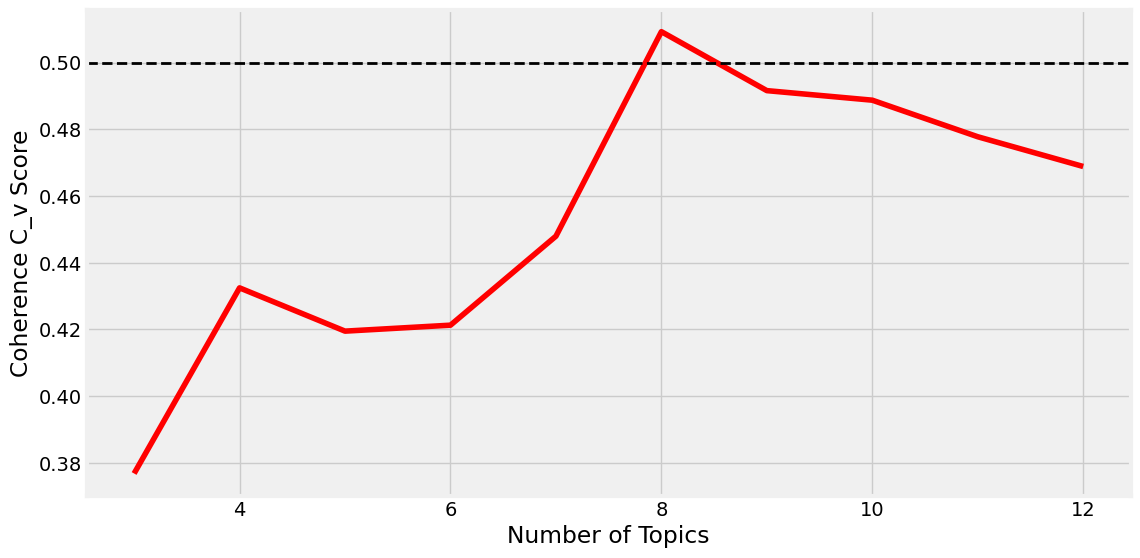

In [29]:
%%time
# WARNING: Long run times!!!
lda_models, coherence_df, coherence_plot = topic_modeling_by_coherence(bow_corpus=bow_corpus, conversations=norm_conversations_bigrams, dictionary=dictionary,
                                                     start_topic_count=3, end_topic_count=12, step=1)

In [30]:
coherence_df

,Number of Topics,C_v Score,UMass Score,Perplexity Score,Warnings
0,3,0.3768,-1.3873,-6.0673,None
1,4,0.4324,-1.3192,-6.0029,None
2,5,0.4195,-1.3985,-5.9839,None
3,6,0.4212,-1.5697,-5.9679,None
4,7,0.4479,-2.0051,-5.9671,None
5,8,0.5093,-1.6255,-5.9467,None
6,9,0.4916,-2.0013,-5.9602,None
7,10,0.4887,-2.0229,-5.9875,None
8,11,0.4777,-1.8375,-6.0771,None
9,12,0.4688,-1.8359,-6.2306,None


In [25]:
best_model_idx = coherence_df['C_v Score'].idxmax()
best_lda_model = lda_models[best_model_idx]

topics = [[(term, round(wt, 3))
               for term, wt in best_lda_model.show_topic(n, topn=20)]
                   for n in range(0, best_lda_model.num_topics)]

for idx, topic in enumerate(topics):
    print('Topic #'+str(idx+1)+':')
    print([term for term, wt in topic])
    print()

topics_df = pd.DataFrame([', '.join([term for term, wt in topic])
                              for topic in topics],
                         columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, best_lda_model.num_topics+1)]
                         )
topics_df

Topic #1:
['provide', 'information', 'order', 'please', 'status', 'help', 'purchase', 'check', 'detail', 'assist', 'rebate', 'need', 'current_status', 'could', 'thank', 'update', 'assistance', 'number', 'accurate', 'understand']

Topic #2:
['team', 'customer', 'support', 'website', 'reach', 'dedicated', 'contact', 'live_chat', 'assist', 'know', 'assistance', 'find', 'need', 'service', 'available', 'happy', 'retrieve', 'section', 'help', 'report']

Topic #3:
['address', 'shipping', 'delivery', 'information', 'detail', 'account', 'please', 'new', 'provide', 'let', 'edit', 'assist', 'need', 'ensure', 'step', 'add_new', 'process', 'specific', 'secondary', 'make']

Topic #4:
['issue', 'provide', 'feedback', 'help', 'process', 'please', 'problem', 'assist', 'detail', 'address', 'could', 'understand', 'ensure', 'specific', 'rest_assured', 'appreciate', 'assistance', 'experience', 'error', 'better']

Topic #5:
['invoice', 'bill', 'let', 'please', 'download', 'tracking', 'key', 'need', 'number'

,Terms per Topic
Topic1,"provide, information, order, please, status, h..."
Topic2,"team, customer, support, website, reach, dedic..."
Topic3,"address, shipping, delivery, information, deta..."
Topic4,"issue, provide, feedback, help, process, pleas..."
Topic5,"invoice, bill, let, please, download, tracking..."
Topic6,"account, option, process, step, section, profi..."
Topic7,"refund, product, reimbursement, service, reque..."
Topic8,"payment, option, method, need, item, experienc..."


In [16]:
tm_results = best_lda_model[bow_corpus]

corpus_topics = [sorted(topics, key=lambda record: -record[1])[0]
                     for topics in tm_results]

corpus_topic_df = pd.DataFrame()
corpus_topic_df['Original Category'] = bitext_df["category"]
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Desc'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
corpus_topic_df['Conversation'] = bitext_df["conversation"]
corpus_topic_df.sample(10)

,Original Category,Dominant Topic,Contribution %,Topic Desc,Conversation
7784,FEEDBACK,4,76.35,"issue, provide, feedback, help, process, pleas...","Question: I am unhappy with your work, how do ..."
24262,ACCOUNT,6,86.18,"account, option, process, step, section, profi...",Question: wanna use the premium account Answer...
7625,FEEDBACK,4,72.01,"issue, provide, feedback, help, process, pleas...",Question: how do I make a complaint against y...
2545,SHIPPING,3,63.88,"address, shipping, delivery, information, deta...","Question: I have submitted a wrong address, he..."
943,ORDER,6,54.22,"account, option, process, step, section, profi...",Question: I can no longer afford purchase {{Or...
19194,ORDER,8,30.27,"payment, option, method, need, item, experienc...",Question: I don't know how I can shop several ...
3567,CANCEL,1,35.77,"provide, information, order, please, status, h...",Question: I want help to check the early termi...
24688,ACCOUNT,6,97.43,"account, option, process, step, section, profi...",Question: assistance to use the {{Account Cate...
6642,REFUND,7,54.40,"refund, product, reimbursement, service, reque...",Question: help me check inwhat cases can i ask...
11587,ACCOUNT,4,59.54,"issue, provide, feedback, help, process, pleas...",Question: problem with the termination of my p...


## Topic Modeling with Scikit-Learn

### Add bigrams like in Gensim - NOT WORKING CURRENTLY

In [ ]:
# # Done with the help of ChatGPT
# Needs work

# tokenized_conversation = norm_conversations[0]
# stop_words = set(nltk.corpus.stopwords.words('english'))
# bigram_lists = [list(nltk.bigrams([word for word in conversation if word not in stop_words])) for conversation in norm_conversations[0:20]]
# print(bigram_lists)
# # Count the frequencies of each bigram
# bigram_counter = Counter([bigram for sublist in bigram_lists for bigram in sublist])

# # Filter bigrams based on frequency
# min_count = 20
# threshold = 10
# frequent_bigrams = {bigram: count for bigram, count in bigram_counter.items() if count >= min_count}

# # Fuse the bigrams back into the conversations
# # Replace the words in bigrams with the concatenated version

# def fuse_bigrams(conversation, frequent_bigrams):
#     new_conversation = []
#     skip_next = False
#     for i in range(len(conversation) - 1):
#         if skip_next:
#             skip_next = False
#             continue
#         bigram = (conversation[i], conversation[i + 1])
#         if bigram in frequent_bigrams:
#             new_conversation.append('_'.join(bigram))
#             skip_next = True
#         else:
#             new_conversation.append(conversation[i])
#     if not skip_next:
#         new_conversation.append(conversation[-1])
#     return new_conversation

# norm_conversation_bigrams = [fuse_bigrams(conversation, frequent_bigrams) for conversation in tokenized_conversation]

### LDA Topic Modeling

In [17]:
# TODO: try with spacy to see if it's faster
stop_words = nltk.corpus.stopwords.words('english')
wtk = nltk.tokenize.RegexpTokenizer(r'\w+')
wnl = nltk.stem.wordnet.WordNetLemmatizer()

def normalize_corpus(conversations):
    norm_conversations = []
    for conversation in tqdm.tqdm(conversations):
        conversation = conversation.lower()
        # remove entities:
        conversation = re.sub(r'\{\{.*?\}\}', '', conversation)
        # tokenize and lemmatize:
        conversation_tokens = [token.strip() for token in wtk.tokenize(conversation)]
        conversation_tokens = [wnl.lemmatize(token) for token in conversation_tokens if not token.isnumeric()]
        # removing any single character words \ numbers \ symbols:
        conversation_tokens = [token for token in conversation_tokens if len(token) > 1]
        # remove stop words:
        conversation_tokens = [token for token in conversation_tokens if token not in stop_words]
        # remove faulty types and empty conersations:
        conversation_tokens = list(filter(None, conversation_tokens))
        conversation_single_string = " ".join(conversation_tokens)

        if conversation_single_string:
            norm_conversations.append(conversation_single_string)

    return norm_conversations

norm_conversations = normalize_corpus(bitext_df["conversation"].to_list())
print(len(norm_conversations))

100%|██████████| 26872/26872 [00:21<00:00, 1255.65it/s]

26872


In [18]:
%%time
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_df=0.9, min_df=5, ngram_range=(1, 2), stop_words='english')
X = vectorizer.fit_transform(norm_conversations)

lda = LatentDirichletAllocation(n_components=8,
                                batch_size=128,
                                max_iter=100,
                                random_state=7)
lda.fit(X)

CPU times: user 9min 12s, sys: 2.04 s, total: 9min 15s
Wall time: 9min 28s


LatentDirichletAllocation(max_iter=100, n_components=8, random_state=7)

In [ ]:
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]))

Topic 0:
order provide purchase help information assist number assistance need team
Topic 1:
email account user pin step password access process profile key
Topic 2:
refund service request charge product reimbursement specific policy assist provide
Topic 3:
payment option method shipping payment method need delivery available item let
Topic 4:
issue provide feedback help assist problem process customer payment error
Topic 5:
address invoice account shipping shipping address step need section let delivery
Topic 6:
account information provide process newsletter ensure assist step rest assured
Topic 7:
account option profile section process setting switch account setting help navigate


In [ ]:
# Gensim format:
# Used only for the score
from gensim.corpora.dictionary import Dictionary

nlp = spacy.load("en_core_web_sm")
texts = [[word for word in document.lower().split() if word not in set(nlp.Defaults.stop_words)] for document in norm_conversations]
dictionary = Dictionary(texts)

def extract_top_words_per_topic(lda_model, feature_names, n_top_words):
    top_words_per_topic = []
    for topic_idx, topic in enumerate(lda_model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words_per_topic.append(top_words)
    return top_words_per_topic

corpus = [dictionary.doc2bow(text) for text in texts]
top_words_per_topic = extract_top_words_per_topic(lda, feature_names, n_top_words=20)

from gensim.models.coherencemodel import CoherenceModel
coherence_model = CoherenceModel(topics=top_words_per_topic, texts=texts, dictionary=dictionary, coherence='c_v')

coherence_score = coherence_model.get_coherence()

print(f'Coherence Score: {coherence_score}')


Coherence Score: 0.5118184065334548


## Topic Modeling with BERTopic

In [ ]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
import gensim

In [ ]:
import gensim.corpora as corpora

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from gensim.models.coherencemodel import CoherenceModel

In [ ]:
# TODO: try with spacy to see if it's faster
stop_words = nltk.corpus.stopwords.words('english')
wtk = nltk.tokenize.RegexpTokenizer(r'\w+')
wnl = nltk.stem.wordnet.WordNetLemmatizer()

def normalize_corpus(conversations):
    norm_conversations = []
    for conversation in tqdm.tqdm(conversations):
        conversation = conversation.lower()
        # remove entities:
        conversation = re.sub(r'\{\{.*?\}\}', '', conversation)
        # tokenize and lemmatize:
        conversation_tokens = [token.strip() for token in wtk.tokenize(conversation)]
        conversation_tokens = [wnl.lemmatize(token) for token in conversation_tokens if not token.isnumeric()]
        # removing any single character words \ numbers \ symbols:
        #conversation_tokens = [token for token in conversation_tokens if len(token) > 1]
        # remove stop words:
        #conversation_tokens = [token for token in conversation_tokens if token not in stop_words]
        # remove faulty types and empty conersations:
        conversation_tokens = list(filter(None, conversation_tokens))
        conversation_single_string = " ".join(conversation_tokens)

        if conversation_single_string:
            norm_conversations.append(conversation_single_string)

    return norm_conversations

norm_conversations = normalize_corpus(bitext_df["conversation"].to_list())
print(len(norm_conversations))

100%|██████████| 26872/26872 [00:14<00:00, 1900.52it/s]

26872


In [ ]:
%%time
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
# Step 2.2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')
# Step 2.3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

vectorizer_model = CountVectorizer(stop_words="english")
ctfidf_model = ClassTfidfTransformer()


topic_model = BERTopic(
  embedding_model=embedding_model,    # Step 1 - Extract embeddings
  umap_model=umap_model,              # Step 2 - Reduce dimensionality
  # hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words
  nr_topics=15,                        # Step 6 - Diversify topic words
  min_cluster_size=
)


topic_model = BERTopic(language="english",
    min_topic_size=100,
    calculate_probabilities=False,
    verbose=False)

topics, probabilities = topic_model.fit_transform(norm_conversations)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

CPU times: user 30min 49s, sys: 4min 14s, total: 35min 3s
Wall time: 35min 2s


In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_barchart()

In [ ]:
documents = pd.DataFrame({"Document": norm_conversations,
                          "ID": range(len(norm_conversations)),
                          "Topic": topics})
documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

# Extract vectorizer and analyzer from BERTopic
vectorizer = topic_model.vectorizer_model
analyzer = vectorizer.build_analyzer()

words = vectorizer.get_feature_names_out()
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in topic_model.get_topic(topic)]
               for topic in range(len(set(topics))-1)]

coherence_model = CoherenceModel(topics=topic_words,
                                 texts=tokens,
                                 corpus=corpus,
                                 dictionary=dictionary,
                                 coherence='c_v')
coherence = coherence_model.get_coherence()


In [ ]:
len(topics)

26872

In [ ]:
coherence

0.6931507664639363

## Compare models

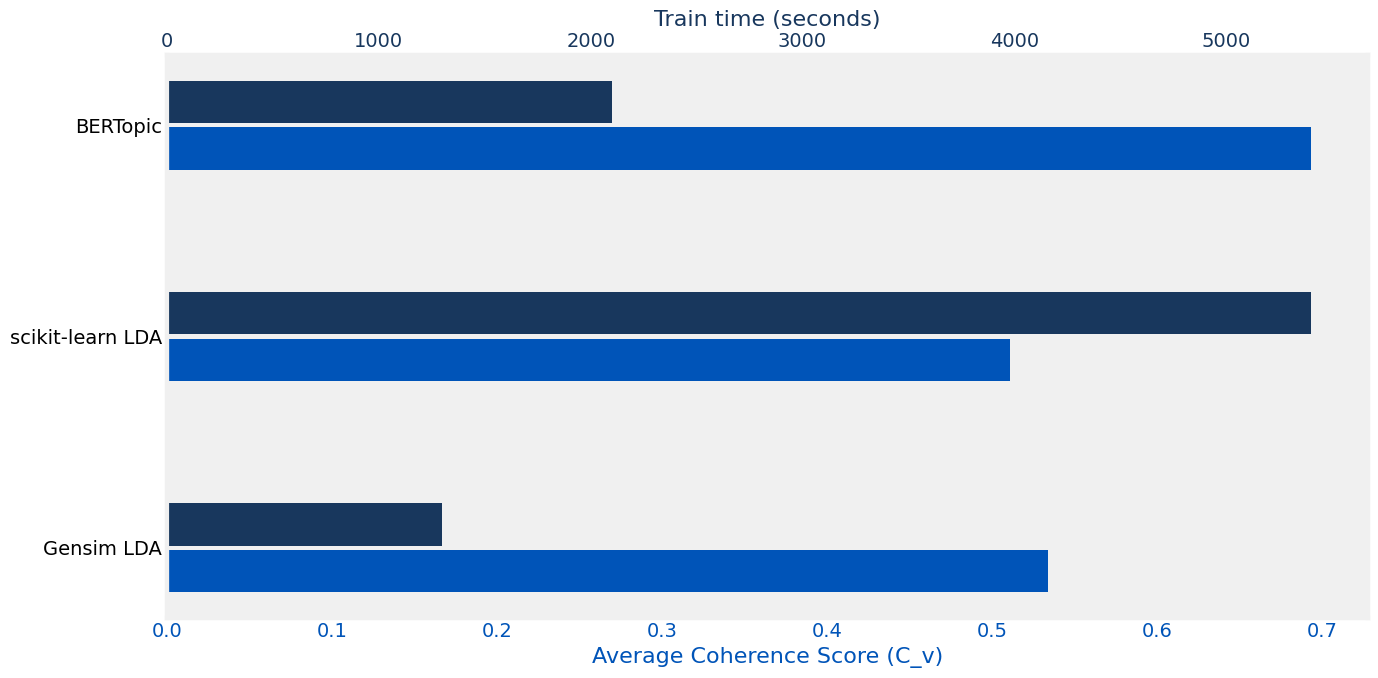

In [49]:
evaluation = {
    "Model" : ["Gensim LDA", "scikit-learn LDA", "BERTopic"],
    "Average C_v Coherence Score" : [0.534, 0.511, 0.693],
    "Train time" : [1300, 5400, 2100]
}

df = pd.DataFrame(evaluation)
indices = range(len(df['Model']))

# Adjusting the figure size and bar width for better visibility and separation
fig, ax1 = plt.subplots(figsize=(14, 7))
bar_width = 0.2  # Adjusted bar width
model_spacing = 1.0  # Increased spacing between each model
separation = 0.22

# Creating new indices to accommodate increased spacing between models
new_indices = [i * model_spacing for i in indices]

# Plotting the coherence scores with adjusted indices
ax1.barh([i - separation/2 for i in new_indices], df['Average C_v Coherence Score'], height=bar_width, color='#0054B8', label='Average C_v Coherence Score')

# Creating a second axis for the train time
ax2 = ax1.twiny()
ax2.set_xlabel('Train time (seconds)', color='#18375D', fontsize=16)
ax2.tick_params(axis='x', colors='#18375D')

# Plotting the training times with adjusted indices
ax2.barh([i + separation/2 for i in new_indices], df['Train time'], height=bar_width, color='#18375D', label='Train time (s)')

# Setting the y-ticks to match the new indices and labeling them with the model names
ax1.set(yticks=new_indices, yticklabels=df['Model'])

# Adding labels and title
ax1.set_xlabel('Average Coherence Score (C_v)', color='#0054B8', fontsize=16)
ax1.tick_params(axis='x', colors='#0054B8')
# plt.title('Model Comparison')

# Adding a legend
# ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)
# ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), shadow=True, ncol=2)

# Removing grid lines and hiding legends
ax1.grid(False)
ax2.grid(False)
ax1.legend().set_visible(False)
ax2.legend().set_visible(False)

# Display the updated plot
plt.tight_layout()
plt.show()

# Trained on a Colab specs